# Black-Litterman model

An asset allocation model which is considered to be an adaptation of Modern Portfolio Theory, which only included market historical data, and constructs portfolios based on those returns.

This model instead takes into account the investor's views of the asset's future performance, and constructs more optimal portfolios with those performance views.

## Download stock data

In [43]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [44]:
# Get the stock tickers
tickers = ['PLTR', 'ATVI', 'NIO', 'NEGG', 'AAPL', 'LOVE', 'JYNT', 'CELH', 'AMD', 'SOFI']

In [45]:
# Download the adjusted closing prices of the stocks
df = yf.download(tickers, period='max')
prices = df['Adj Close']
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AAPL,AMD,ATVI,CELH,JYNT,LOVE,NEGG,NIO,PLTR,SOFI
Date,,,,,,,,,,
2021-10-04,139.139999,100.339996,77.180000,90.620003,91.820000,65.800003,13.22,33.400002,23.170000,16.090000
2021-10-05,141.110001,101.809998,76.800003,94.919998,95.080002,70.809998,13.77,33.869999,23.209999,16.250000
2021-10-06,142.000000,103.639999,77.290001,94.459999,96.419998,72.150002,13.87,33.660000,23.580000,16.620001
2021-10-07,143.289993,106.449997,77.360001,97.620003,85.529999,71.320000,14.19,35.990002,23.730000,16.400000
2021-10-08,142.899994,105.059998,77.610001,94.099998,80.099998,71.830002,13.63,35.830002,23.500000,16.209999


In [46]:
# Get the Adjusted closing price of the S&P 500
market_prices = yf.download('SPY', period='max')['Adj Close']
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.717381
1993-02-01    25.900303
1993-02-02    25.955166
1993-02-03    26.229532
1993-02-04    26.339281
Name: Adj Close, dtype: float64

In [47]:
# Download data containing market caps of all the stocks 
from pandas_datareader import data

mcaps = data.get_quote_yahoo(tickers)['marketCap']

In [48]:
mcaps

PLTR      45898321920
ATVI      60357922816
NIO       58712117248
NEGG       5019915776
AAPL    2362165428224
LOVE       1085961856
JYNT       1151525632
CELH       7008784896
AMD      127434620928
SOFI      12962001920
Name: marketCap, dtype: int64

## Getting market-implied returns

In [49]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [50]:
# Get the market-implied risk aversion parameter
# Use the Ledoit-Wolf shrinkage estimator

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.7432945672209192

<AxesSubplot:>

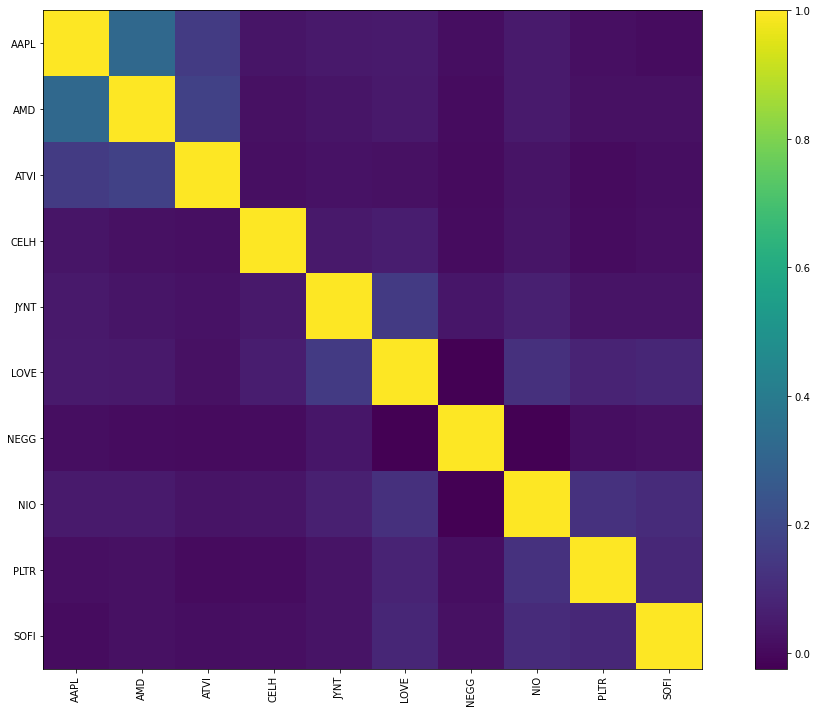

In [51]:
# Plot the covariance matrix
plotting.plot_covariance(S, plot_correlation=True)

In [52]:
# Get the prior estimate of returns implied by market weights 
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.04)
market_prior

AAPL    0.538585
AMD     0.296138
ATVI    0.129539
CELH    0.077842
JYNT    0.053718
LOVE    0.055822
NEGG    0.051477
NIO     0.062023
PLTR    0.044686
SOFI    0.042735
dtype: float64

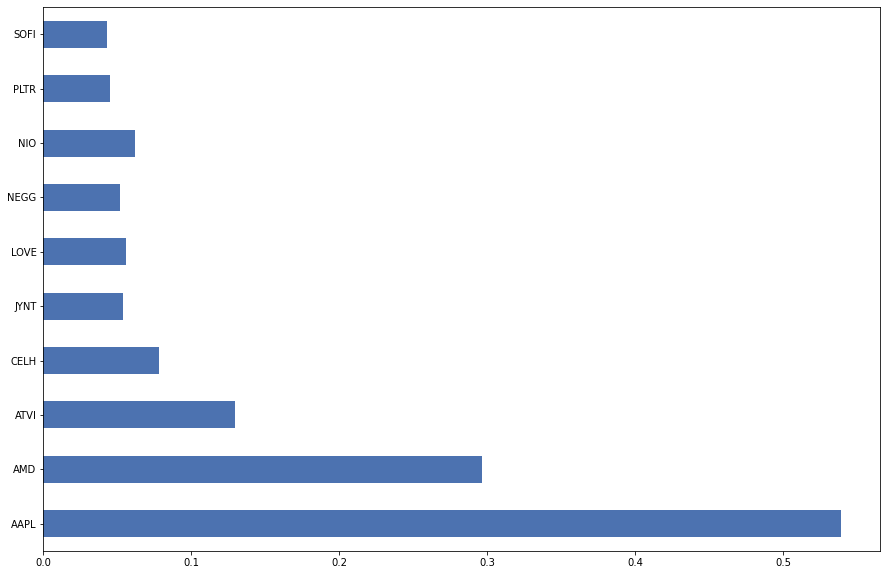

In [53]:
# PLot the market-implied returns
market_prior.plot.barh();

## Provide absolute views of assets' performance

In [54]:
viewdict = {
    'AAPL':0.6,
    'PLTR':0.2,
    'ATVI':0.2,
    'JYNT':0.2,
    'LOVE':0.2,
    'NEGG':0.2,
    'NIO':0.1,
    'CELH':0.1,
    'AMD':0.2
    
}

In [55]:
# Provide confidence percentages of asset performance
confidences = [
    0.8,
    0.6,
    0.6,
    0.7,
    0.4,
    0.6,
    0.4,
    0.4,
    0.5
]


In [56]:
# Input the Black-Litterman model 
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega='idzorek',
                         view_confidences=confidences)

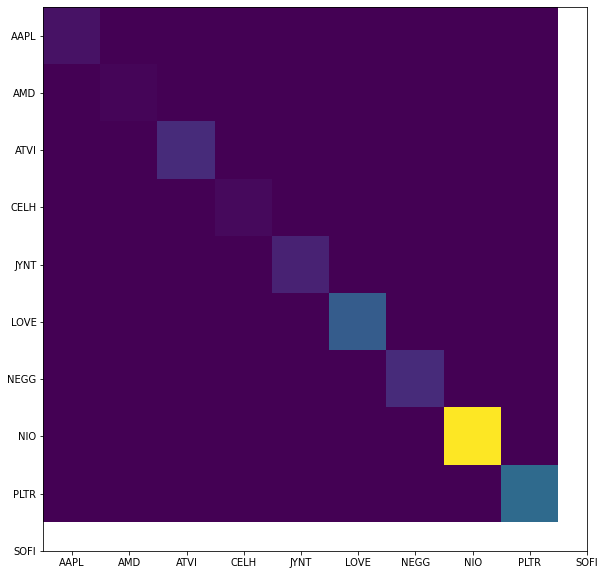

In [57]:
# Show the uncertainty matrix
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(bl.omega)

# show all ticks
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [58]:
np.diag(bl.omega)

array([0.00250911, 0.00072232, 0.00628933, 0.0012479 , 0.00494081,
       0.01477191, 0.00625031, 0.05064063, 0.01756473])

## Posterior Estimates

Compute posterior estimate of returns

In [59]:
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.589038
AMD     0.272903
ATVI    0.174039
CELH    0.105942
JYNT    0.159981
LOVE    0.129592
NEGG    0.145465
NIO     0.098335
PLTR    0.139486
SOFI    0.055589
dtype: float64

In [60]:
# Visualize the comparison between prior and posterior views
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
                      index=['Prior', 'Posterior','Views']).T
rets_df

,Prior,Posterior,Views
AAPL,0.538585,0.589038,0.6
AMD,0.296138,0.272903,0.2
ATVI,0.129539,0.174039,0.2
CELH,0.077842,0.105942,0.1
JYNT,0.053718,0.159981,0.2
LOVE,0.055822,0.129592,0.2
NEGG,0.051477,0.145465,0.2
NIO,0.062023,0.098335,0.1
PLTR,0.044686,0.139486,0.2
SOFI,0.042735,0.055589,NaN


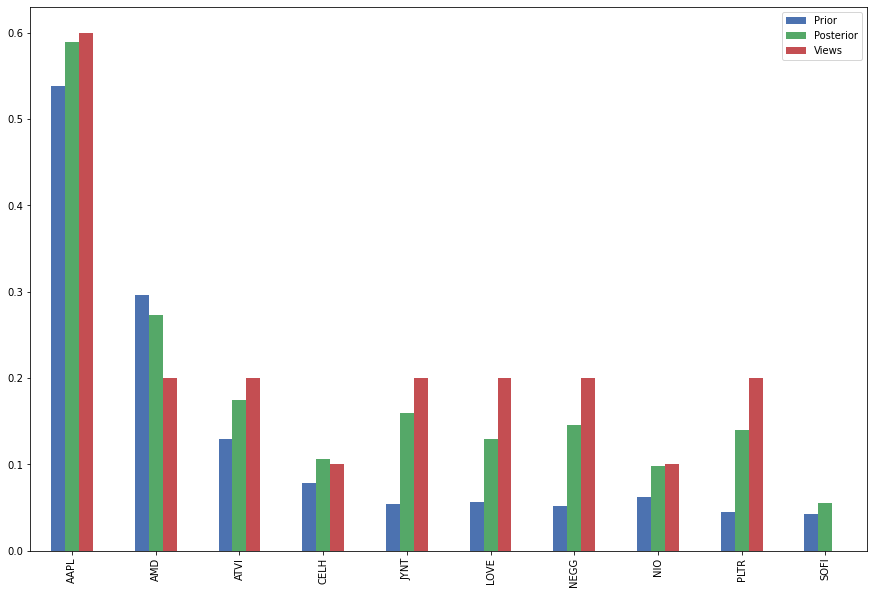

In [61]:
# Plot the above
rets_df.plot.bar();

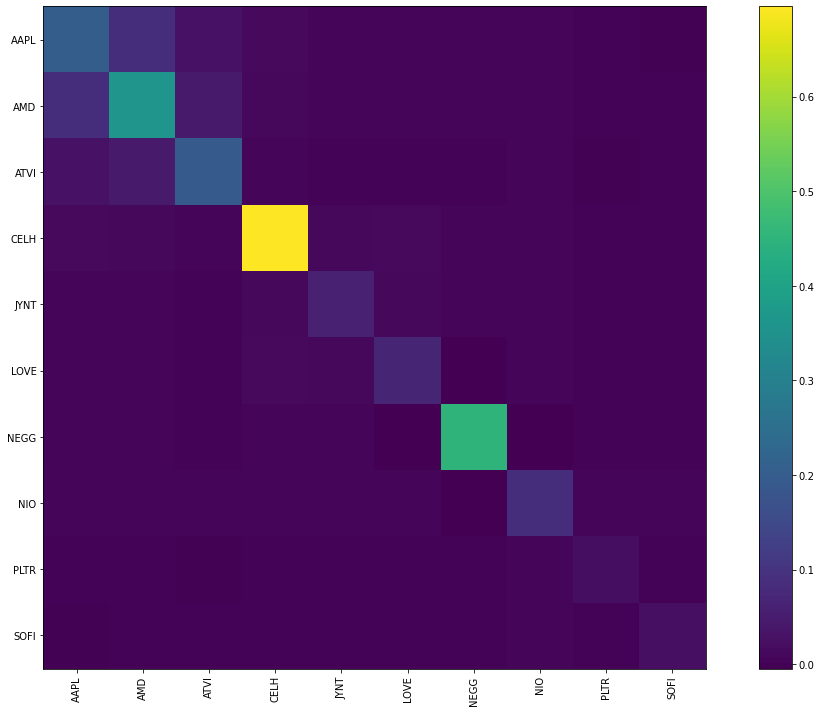

In [62]:
# Plot covariance matrix
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

# Portfolio Optimization

## Optimize for maximum sharpe ratio

In [63]:
from pypfopt import EfficientFrontier, objective_functions

In [64]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.22523),
             ('AMD', 0.0),
             ('ATVI', 0.02837),
             ('CELH', 0.00138),
             ('JYNT', 0.15719),
             ('LOVE', 0.07323),
             ('NEGG', 0.01895),
             ('NIO', 0.01532),
             ('PLTR', 0.41947),
             ('SOFI', 0.06088)])

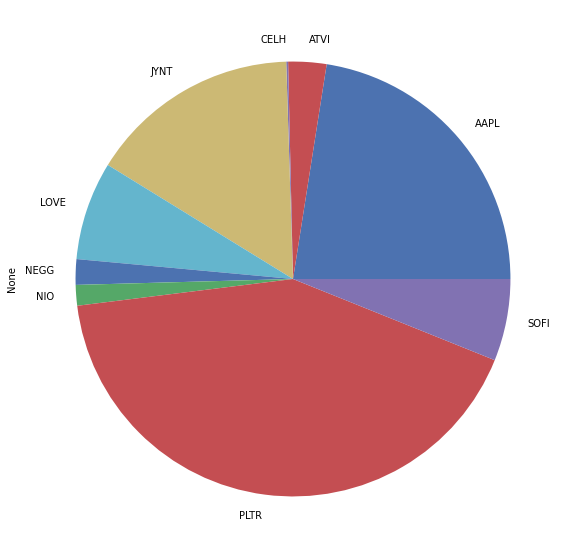

In [65]:
pd.Series(weights).plot.pie();

In [66]:
ef.portfolio_performance(verbose=True);

Expected annual return: 23.9%
Annual volatility: 13.6%
Sharpe Ratio: 1.60


In [67]:
# Allocate capital into the portfolio
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=2000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $0.73


{'AAPL': 3,
 'ATVI': 1,
 'JYNT': 4,
 'LOVE': 2,
 'NEGG': 3,
 'NIO': 1,
 'PLTR': 35,
 'SOFI': 8}

## Optimize for minimum volatility

In [68]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.02618),
             ('AMD', 0.00612),
             ('ATVI', 0.03531),
             ('CELH', 0.00667),
             ('JYNT', 0.11808),
             ('LOVE', 0.0752),
             ('NEGG', 0.01648),
             ('NIO', 0.04893),
             ('PLTR', 0.34833),
             ('SOFI', 0.31868)])

C:\Users\Huy Doan\anaconda3\envs\quant\lib\site-packages\pandas\plotting\_matplotlib\core.py:1616: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


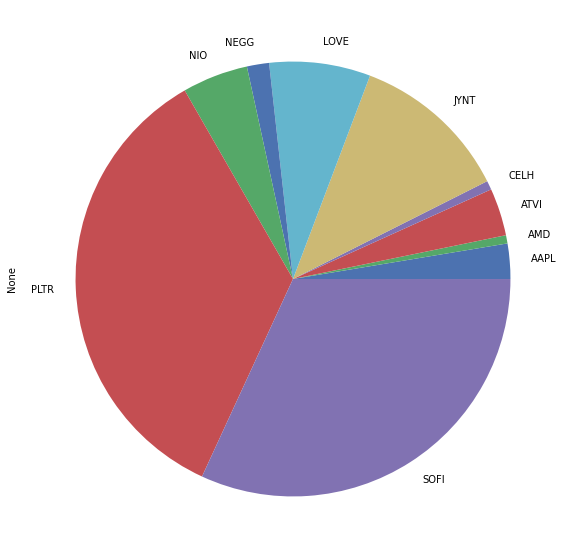

In [69]:
pd.Series(weights).plot.pie();

In [70]:
ef.portfolio_performance(verbose=True);

Expected annual return: 12.6%
Annual volatility: 9.5%
Sharpe Ratio: 1.12


In [71]:
latest_prices = prices.iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=2000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $36.65


{'ATVI': 1, 'JYNT': 3, 'LOVE': 2, 'NEGG': 3, 'NIO': 3, 'PLTR': 30, 'SOFI': 40}

## Add sector constraints to optimize for a better max-sharpe ratio

In [72]:
sector_mapper = {
    'PLTR':'online services', 
    'ATVI':'online services', 
    'AMD':'semiconductors', 
    'NEGG':'online services', 
    'AAPL':'phone & handheld devices',  
    'LOVE':'home furnishings', 
    'NIO':'auto',
    'JYNT':'healthcare', 
    'CELH':'beverages',
    'SOFI':'finance'
}

sector_lower = {'online services': 0.15}
sector_upper = {'online services':0.4}

In [73]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.22945),
             ('AMD', 0.0),
             ('ATVI', 0.02146),
             ('CELH', 0.00206),
             ('JYNT', 0.16835),
             ('LOVE', 0.08206),
             ('NEGG', 0.01647),
             ('NIO', 0.0241),
             ('PLTR', 0.36207),
             ('SOFI', 0.09398)])

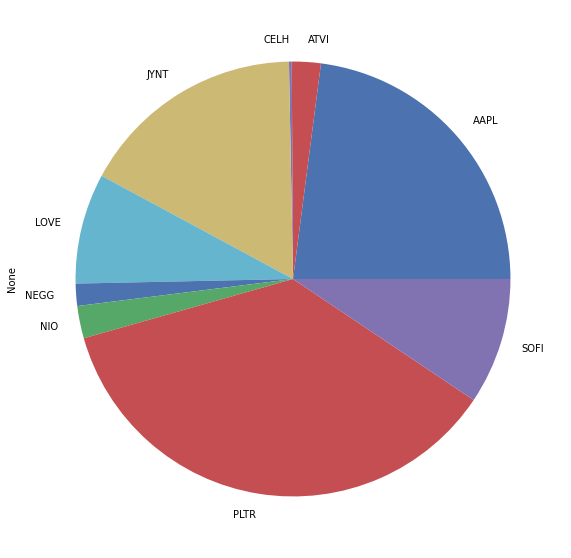

In [74]:
pd.Series(weights).plot.pie();

In [75]:
ef.portfolio_performance(verbose=True);

Expected annual return: 23.7%
Annual volatility: 13.6%
Sharpe Ratio: 1.60


In [76]:
latest_prices = prices.iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=2000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $7.69


{'AAPL': 3,
 'ATVI': 1,
 'JYNT': 4,
 'LOVE': 2,
 'NEGG': 2,
 'NIO': 2,
 'PLTR': 31,
 'SOFI': 12}

## Optimize the portfolio for a given volatility level 

In [77]:
from pypfopt import objective_functions

In [78]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(0.12) # we want a portfolio with at most 12% volatility
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.1796),
             ('AMD', 0.0),
             ('ATVI', 0.02513),
             ('CELH', 0.00322),
             ('JYNT', 0.15602),
             ('LOVE', 0.08052),
             ('NEGG', 0.01647),
             ('NIO', 0.03043),
             ('PLTR', 0.3584),
             ('SOFI', 0.15021)])

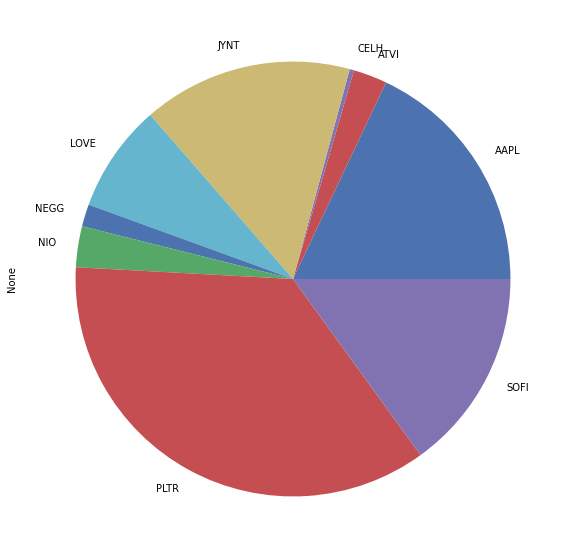

In [79]:
pd.Series(weights).plot.pie();

In [80]:
ef.portfolio_performance(verbose=True);

Expected annual return: 21.0%
Annual volatility: 12.0%
Sharpe Ratio: 1.58
